## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.   

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('project_files/ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
unique_users_converted = (df.query('converted== 1').nunique() / df.user_id.nunique()).user_id
print(unique_users_converted * 100) #result in percentage

12.104245244060237


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group != "treatment" and landing_page == "new_page"').shape[0] + \
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.columns[df.isnull().any()]

Index([], dtype='object')

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query(' group == "control" & landing_page == "old_page" | group == "treatment" & landing_page == "new_page" ')
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id ==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(2893)
df2.query('user_id ==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
probability = df2[df2.converted==1].shape[0]/df2.shape[0]
print ("The probability of an individual converting regardless of the page is: {:.4f}".format(probability))

The probability of an individual converting regardless of the page is: 0.1196


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_gr_prob = df2[(df2['converted']==1) & (df2['group']== 'control') ].shape[0]/\
(df2[df2['group']=='control'].shape[0])
print ("The probability of an individual converting from the control group: {:.4f}".format(control_gr_prob))

The probability of an individual converting from the control group: 0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_gr_prob = df2[(df2['converted']==1) & (df2['group']== 'treatment') ].shape[0]/\
(df2[df2['group']=='treatment'].shape[0])
print ("The probability of an individual converting from the treatment group: {:.4f}".format(treatment_gr_prob))

The probability of an individual converting from the treatment group: 0.1188


d. What is the probability that an individual received the new page?

In [17]:
new_page_prob = df2[(df2['landing_page']=='new_page')].shape[0]/ df2.shape[0]
print ("The probability that an individual received the new page is: {:.4f}".format(new_page_prob))

The probability that an individual received the new page is: 0.5001


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

### **Answer:**   
The probabilities of both groups are quite similar. The percentage of converted in the control group is 12.04% and converted in the treatment group is 11.88%. This is a very small difference in probability rates. Therefore, this means there is not enough evidence to conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

### **Answer:**   
**Null hypothesis** - If the P-value is less than 5%, the old page has a better chance of converting users.   
**Alternative hypothesis** - if the P-value is equal to or greater than 5%, then the new page has a better chance of converting users.   
$H_0:$  $p_{new}$ - $p_{old}$ <= 0   
$H_1:$ $p_{new}$ - $p_{old}$ > 0   
**Type one error:** 5%

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new_convert_null = df2.converted.mean()
print ("The conversion rate for p_new under the null is: {:.4f}".format(p_new_convert_null))

The conversion rate for p_new under the null is: 0.1196


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old_convert_null = df2.converted.mean()
print ("The conversion rate for p_old under the null is: {:.4f}".format(p_old_convert_null))

The conversion rate for p_old under the null is: 0.1196


c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new_treatment_group = df2.query('group == "treatment"').shape[0]
print ("n_new in the treatment group is: {}".format(n_new_treatment_group))

n_new in the treatment group is: 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old_control_group = df2.query('group == "control"').shape[0]
print ("n_old in the control group is: {}".format(n_old_control_group))

n_old in the control group is: 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size = n_new_treatment_group, p = [p_new_convert_null, 1 - p_new_convert_null])
new_page_converted.mean()

0.8799325579794921

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size = n_old_control_group, p = [p_old_convert_null, 1 - p_old_convert_null])
old_page_converted.mean()

0.8819127992620841

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
print(p_diff)

-0.001980241282591999


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
# Create a sampling distribution of the difference with bootstrapping
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new_treatment_group, p = [p_new_convert_null, 1 - p_new_convert_null])
    old_page_converted = np.random.choice([0, 1], size = n_old_control_group, p = [p_old_convert_null, 1 - p_old_convert_null])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
# Transform to a NumPy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

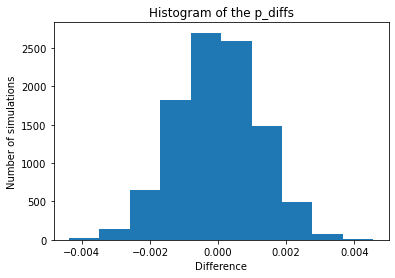

In [26]:
plt.hist(p_diffs);
plt.title('Histogram of the p_diffs');
plt.xlabel('Difference');
plt.ylabel('Number of simulations');

This Histogram above is what we expect. The bell curve resembles a normal distribution.

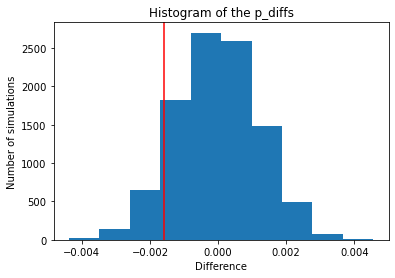

In [27]:
#Сalculate where the observed statistic fall
obs_diff = treatment_gr_prob - control_gr_prob

plt.hist(p_diffs);
plt.axvline(obs_diff, c = 'r');
plt.title('Histogram of the p_diffs');
plt.xlabel('Difference');
plt.ylabel('Number of simulations');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Calculate the actual difference in the original dataset
a_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

# Calculate the proportion of p_diffs are greater than a_diffs
(p_diffs > a_diffs).mean()

0.9004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### **Answer:**   
We computed P-value in part **j**. The p-value tells to us the probability of getting our statistic or a more extreme value if the null is true. We found the P-value is 0.9 that greater than alpha level (.05) and this indicates that we fail reject the $H_0$. This means that the old page is better or equal than the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]
print("convert_old:", convert_old)
print("convert_new:", convert_new)
print("n_old:", n_old)
print("n_new:", n_new)

convert_old: 17489
convert_new: 17264
n_old: 145274
n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print("z_score:", z_score)
print("P_value:", p_value)

z_score: -1.3109241984234394
P_value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

### **Answer:**

To interpret the z-score we need to define its critical value.

In [31]:
#Import necessary packages
from scipy.stats import norm

# This tells us how significant our z-score is
norm.cdf(z_score)

0.09494168724097551

In [32]:
#Calculate the critical value at 95% Confidence Interval
norm.ppf(1-0.05)

1.6448536269514722

The z_score is less than the critical value at 95% Confidence Interval. It means that we fail to reject $H_0$ hypothesis. We agree with parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

### **Answer:**   
We should use is **Logistic Regression** because the output of the dependent variable is binary, each row is either a conversion or no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
#Create dummy variables from the 'group' column
df2[['ab_page','treatment']] = pd.get_dummies(df2['group'])

#Drop the 'treatment' column since this is not necessary
df2 = df2.drop('treatment', 1)

#Add the 'intercept' column
df2['intercept'] = 1

df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-02-22 19:16 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

In [37]:
#Find the odds of converted
np.exp(results.params)

intercept    0.134827
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

### **Answer:**   
**Logistic Regression** performed is a two-tailed test, whereas the computation done in **Part II** is a one-tailed test. Here, a two-sided test, the hypotheses are:   
$H_0:$  $p_{old}$ - $p_{new}$ = 0   
$H_1:$ $p_{old}$ - $p_{new}$ $\neq$ 0   
The P-value calculated here is 0.1899 that is still greater then alpha level (.05), so we still fail to reject our Null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

### **Answer:**   
Using more parameters can help the model to have better accuracy. But we may also face the disadvantages of this decision. For example with too many factors the model can produce inaccurate results due to the multicollinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
#Read the new dataset
df_countries = pd.read_csv('project_files/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# Merge the datasets 
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(3)

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1


In [40]:
# Create dummy variables for 'country'
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,0


In [41]:
#Show the number of values in the 'country' column
df_new['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# Create a logistic regression using statsmodels
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-02-22 19:16 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0450    0.0266  -76.8197  0.0000  -2.0971  -1.9928
ab_page        0.0149    0.0114    1.3069  0.1912  -0.0075   0.0374
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

In [43]:
#Find the odds of converted
np.exp(results.params)

intercept    0.129384
ab_page      1.015056
UK           1.051944
US           1.041599
dtype: float64

## Conclusions:   
   In **Part I**, we showed that the probabilities of both groups are quite similar. This means there is not enough evidence to conclude that the new treatment page leads to more conversions.   
   In **Part II**, using a A / B test, We found the P-value is 0.9 that greater than alpha level (.05) and this indicates that we fail reject the  $H_0$. This means that the old page is better or equal than the new page.    
   In **Part III**, we used logistic regression. We observe that even with ab_page the P-value is greater than 0.05 and also if you pay attention to the odds ratio of the interaction between country and ab_page, we have an about equal chance of the ab_page converting users in each country. So, we fail to reject the Null hypothesis. The new page does not convert more than the old page.   
   
   **Based on the conclusions above, we can inference that there is no need for a new page, it will not bring tangible benefits, so we  should stay with the old page.** 